# Imports

In [9]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import altair as alt
import pickle

from typing import Any
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

PATH_TO_DATA = "../data/"
PATH_TO_MODEL = "../models/"


# Chargement des données et pré-traitement

In [ ]:
df = pd.read_csv(PATH_TO_DATA + "dataCleaned.csv")
numeric_df = df.select_dtypes(include=[np.number])

In [11]:
numeric_df.columns

Index(['age', 'membership_category', 'joined_through_referral',
       'days_since_last_login', 'avg_time_spent', 'avg_transaction_value',
       'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount',
       'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score'],
      dtype='object')

In [12]:
df.columns

Index(['age', 'gender', 'security_no', 'region_category',
       'membership_category', 'joining_date', 'joined_through_referral',
       'referral_id', 'preferred_offer_types', 'medium_of_operation',
       'internet_option', 'last_visit_time', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score'],
      dtype='object')

In [13]:
scaler = MinMaxScaler()
for column in numeric_df.columns:
    x = numeric_df[[column]].values
    x_scaled = scaler.fit_transform(x)
    numeric_df[column] = x_scaled

numeric_df.head()

,age,membership_category,joined_through_referral,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,past_complaint,complaint_status,feedback,churn_risk_score
0,0.148148,0.8,0.0,0.64,0.098333,0.526717,0.547827,0.375887,1.0,0.0,0.25,0.0,0.0
1,0.629630,0.0,1.0,0.52,0.169265,0.204074,0.592988,0.239624,0.0,1.0,0.75,1.0,1.0
2,0.500000,0.0,1.0,0.40,0.016927,0.246577,0.448473,0.272092,0.0,1.0,1.00,1.0,1.0
3,0.388889,0.0,0.0,0.76,0.036627,0.238950,0.538795,0.318344,0.0,1.0,0.50,1.0,1.0
4,0.055556,0.6,0.0,0.88,0.142100,0.132013,0.611052,0.347050,1.0,1.0,1.00,0.5,0.0


In [14]:
num_corr = numeric_df.corr()
num_corr['churn_risk_score']
sorted_correlated = num_corr.map(lambda x: abs(x)).sort_values('churn_risk_score', ascending=False)['churn_risk_score'][:10]
sorted_correlated


churn_risk_score            1.000000
membership_category         0.748550
feedback                    0.397336
points_in_wallet            0.316213
avg_transaction_value       0.214946
avg_frequency_login_days    0.134382
joined_through_referral     0.032053
days_since_last_login       0.020117
used_special_discount       0.018048
avg_time_spent              0.014029
Name: churn_risk_score, dtype: float64

In [15]:
correlation = numeric_df.corr()
correlation = correlation['churn_risk_score'].sort_values(ascending=False)

correlation = correlation.to_frame(name='correlation').reset_index()
correlation = correlation.rename(columns={'index': 'variable'})

# Passage en valeur absolue de la corrélation.
correlation['correlation'] = correlation['correlation'].abs()


alt.Chart(correlation).mark_bar().encode(
    x=alt.X('correlation'),
    y=alt.Y('variable').sort('-x'),
    tooltip='correlation',
    color=alt.Color('variable').sort('-x')
).properties(
    title='churn_risk_score Correlation with others variables',
)




alt.Chart(...)

# Matrice de Corrélation

Essayons d'abord de comprendre comment sont corrélés nos attributs d'entrée dans notre dataset.
On note pas de grande redondance entre nos informations, éventuellement au niveau de l'attribut "has completed preparation test"

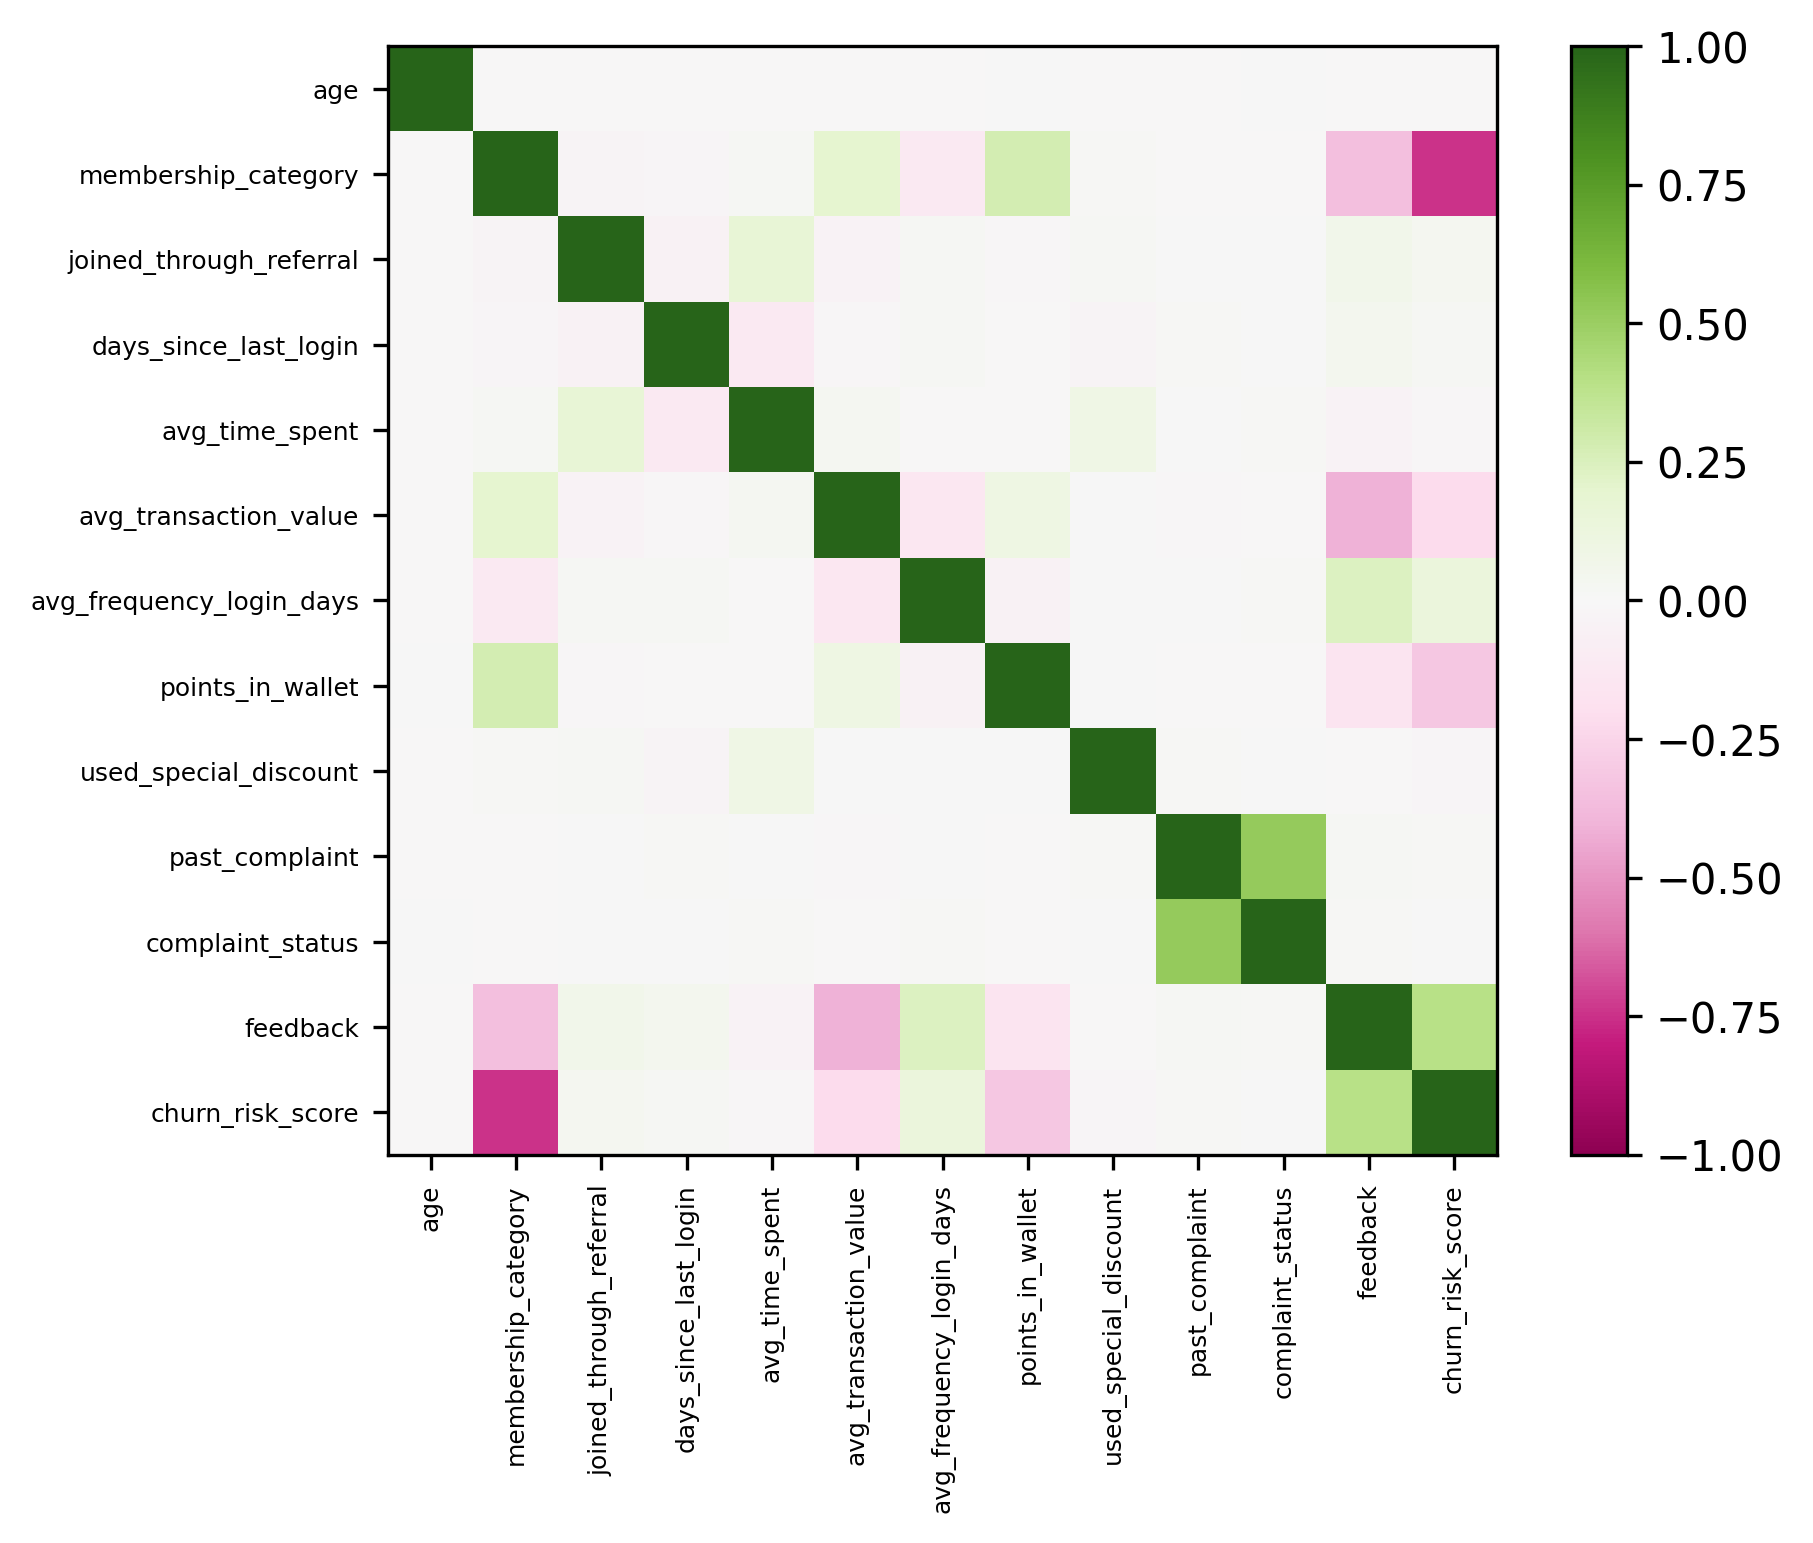

In [16]:
plt.figure(dpi=300)
plt.imshow(num_corr, cmap=plt.get_cmap("PiYG"), vmin=-1, vmax=1) # Pour se convaincre qu'il y a bien de la corrélation
plt.xticks(range(len(numeric_df.columns)), numeric_df.columns, fontsize=6, rotation=90)
plt.yticks(range(len(numeric_df.columns)), numeric_df.columns, fontsize=6)
plt.colorbar()

In [17]:


class GenericModel():
    def __init__(self, X_train, y_train, X_test, y_test, kernel: str = 'logistic_regression'):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        if kernel == 'logistic_regression':
            self.model = LogisticRegression(max_iter=2000)
        elif kernel == 'random_forest':
            self.model = RandomForestClassifier()
        elif kernel == 'svm':
            self.model = SVC()
        elif kernel == 'knn':
            self.model = KNeighborsClassifier()
        elif kernel == 'decision_tree':
            self.model = DecisionTreeClassifier()
        else:
            raise ValueError("Invalid kernel")

    def training_score(self, verbose: bool = True) -> Any:
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)

        accuracy = accuracy_score(self.y_test, y_pred)
        report = classification_report(self.y_test, y_pred)

        if verbose:
            print(f"Accuracy: {accuracy}")
            print("Classification Report:")
            print(report)
        return accuracy, report

In [18]:
def benchmark_model(df, y_col: str ='churn_risk_score') -> Any:
    X_train, X_test, y_train, y_test = train_test_split(df.drop(y_col, axis=1), df[y_col], test_size=0.2, random_state=42)
    logistic_reg = GenericModel(X_train, y_train, X_test, y_test, kernel='logistic_regression')
    random_forest = GenericModel(X_train, y_train, X_test, y_test, kernel='random_forest')
    svm = GenericModel(X_train, y_train, X_test, y_test, kernel='svm')
    knn = GenericModel(X_train, y_train, X_test, y_test, kernel='knn')
    decision_tree = GenericModel(X_train, y_train, X_test, y_test, kernel='decision_tree')
    
    # Training and scoring
    print("------Logistic Regression------")
    logistic_reg.training_score(verbose=True)
    print("------Random Forest------")
    random_forest.training_score(verbose=True)
    print("------SVM------")
    svm.training_score(verbose=True)
    print("------KNN------")
    knn.training_score(verbose=True)
    print("------Decision Tree------")
    decision_tree.training_score(verbose=True)

In [19]:
numeric_df_without_na = numeric_df.dropna(inplace=False)
features = numeric_df_without_na.drop('churn_risk_score', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, numeric_df_without_na.churn_risk_score, test_size=0.2, random_state=42)

benchmark_model(numeric_df_without_na)

------Logistic Regression------
Accuracy: 0.8587704213241617
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      2178
         1.0       0.87      0.87      0.87      2474

    accuracy                           0.86      4652
   macro avg       0.86      0.86      0.86      4652
weighted avg       0.86      0.86      0.86      4652

------Random Forest------
Accuracy: 0.9451848667239897
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      2178
         1.0       0.94      0.95      0.95      2474

    accuracy                           0.95      4652
   macro avg       0.95      0.94      0.94      4652
weighted avg       0.95      0.95      0.95      4652

------SVM------
Accuracy: 0.8529664660361135
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      2178
       

In [20]:
reduced_df = df[['churn_risk_score', "membership_category", "feedback", "points_in_wallet", "avg_transaction_value", "avg_frequency_login_days", "joined_through_referral", "days_since_last_login"]]

reduced_df = reduced_df.dropna(inplace=False)
features = reduced_df.drop('churn_risk_score', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, reduced_df.churn_risk_score, test_size=0.2, random_state=42)
benchmark_model(reduced_df)


------Logistic Regression------
Accuracy: 0.8592003439380912
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2178
           1       0.87      0.87      0.87      2474

    accuracy                           0.86      4652
   macro avg       0.86      0.86      0.86      4652
weighted avg       0.86      0.86      0.86      4652

------Random Forest------
Accuracy: 0.9464746345657782
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2178
           1       0.94      0.96      0.95      2474

    accuracy                           0.95      4652
   macro avg       0.95      0.95      0.95      4652
weighted avg       0.95      0.95      0.95      4652

------SVM------
Accuracy: 0.6137145313843508
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.30      2178
       

In [21]:
#train a new model with cross validation to random forest and compute standard deviation
X = reduced_df.drop('churn_risk_score', axis=1)
y = reduced_df['churn_risk_score']

model = RandomForestClassifier()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
print(f"Accuracy: {scores.mean()}")

# Compute the standard deviation
print(f"Standard Deviation: {scores.std()}")

    

Accuracy: 0.9414343327878403
Standard Deviation: 0.00349447474294867


In [22]:
#train a random forest model with grid search 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = reduced_df.drop('churn_risk_score', axis=1)
y = reduced_df['churn_risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
param_grid = {
    'n_estimators': [400, 500, 1000, 2000, 3000],
    'max_depth': [5, 10, 20, None],

}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END ......................max_depth=5, n_estimators=400; total time=   2.1s
[CV] END ......................max_depth=5, n_estimators=400; total time=   2.1s
[CV] END ......................max_depth=5, n_estimators=400; total time=   2.2s
[CV] END ......................max_depth=5, n_estimators=400; total time=   2.3s
[CV] END ......................max_depth=5, n_estimators=400; total time=   2.3s
[CV] END ......................max_depth=5, n_estimators=500; total time=   2.6s
[CV] END ......................max_depth=5, n_estimators=500; total time=   2.7s
[CV] END ......................max_depth=5, n_estimators=500; total time=   2.7s
[CV] END ......................max_depth=5, n_estimators=500; total time=   2.8s
[CV] END ......................max_depth=5, n_estimators=500; total time=   3.0s
[CV] END .....................max_depth=5, n_estimators=1000; total time=   5.1s
[CV] END .....................max_depth=5, n_estimators=1000; total time=   5.5s
[CV] END ...................

/home/badbben/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...................max_depth=None, n_estimators=500; total time=   5.4s
[CV] END ..................max_depth=None, n_estimators=1000; total time=  10.4s
[CV] END ..................max_depth=None, n_estimators=1000; total time=  10.4s
[CV] END ..................max_depth=None, n_estimators=1000; total time=  10.8s
[CV] END ..................max_depth=None, n_estimators=1000; total time=  10.4s
[CV] END ....................max_depth=20, n_estimators=3000; total time=  31.5s
[CV] END ..................max_depth=None, n_estimators=1000; total time=  11.1s
[CV] END ....................max_depth=20, n_estimators=3000; total time=  31.9s
[CV] END ....................max_depth=20, n_estimators=3000; total time=  32.0s
[CV] END ....................max_depth=20, n_estimators=3000; total time=  31.8s
[CV] END ....................max_depth=20, n_estimators=3000; total time=  33.5s
[CV] END ..................max_depth=None, n_estimators=2000; total time=  20.3s
[CV] END ..................m

Accuracy: 0.9464746345657782
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2178
           1       0.94      0.96      0.95      2474

    accuracy                           0.95      4652
   macro avg       0.95      0.95      0.95      4652
weighted avg       0.95      0.95      0.95      4652

Standard Deviation: 0.00349447474294867


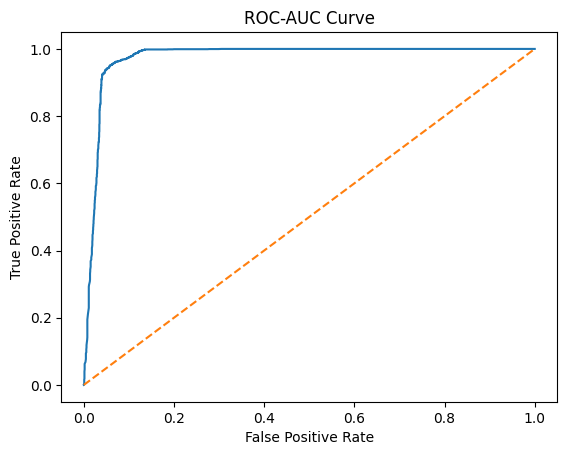

In [23]:
#train a random forest model with the best parameters
model = RandomForestClassifier(n_estimators=3000, max_depth=None)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)
print(f"Standard Deviation: {scores.std()}")

#find the most important features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

#display the roc-auc curve for our model
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()


 

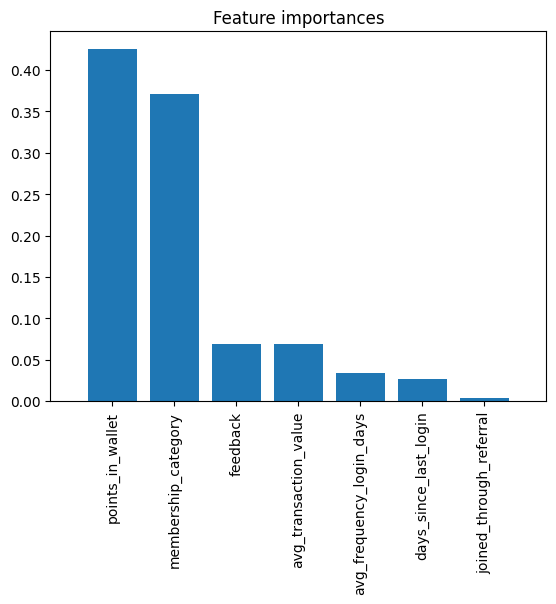

In [24]:

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [25]:
#Analyse models errors to see if there is a pattern in the features
errors = y_test[y_test != y_pred]
X_errors = X_test[y_test != y_pred]

errors_df = pd.DataFrame(X_errors, columns=X.columns)
errors_df['churn_risk_score'] = errors
errors_df.head()

errors_df.describe()

errors_df['churn_risk_score'].value_counts()


churn_risk_score
0    144
1    105
Name: count, dtype: int64

In [ ]:
#save the model in models folder
filename = PATH_TO_MODEL + 'random_forest_3000_model.sav'
pickle.dump(model, open(filename, 'wb'))
